# Running stable-diffusion-x4-upscaler with sagemaker training job

本ノートブックでは，stable diffusion x4 upscalerの推論実行コードをtraining jobで動かせることを検証する．

# setup

In [3]:
!pip install ipywidgets==7.0.0 --quiet
!pip install --upgrade sagemaker


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Using cached sagemaker-2.180.0.tar.gz (867 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 827.6 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 7.1 MB/s eta 0:00:0000:01
  Created wheel for sagemaker: filename=sagemaker-2.180.0-py2.py3-none-any.whl size=1182555 sha256=59acbad819bfe865a028d9618bb705e315a260a2e196f5c2e9cb24d4797d753e
  Stored in directory: /root/.cache/pip/wheels/07/a7/07/c7db95e29daeff62705508b3d6ee55db71e34d7c369d94dfd8
Successfully built sagemaker
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
  Attempting uninstall: attrs
    Found existing installation: attrs 22.2.0
    Uninstalling attrs-22.2.0:
      Successfully uninstalled attrs-22.2.0
  Attempting uninst

# permissions

In [15]:
import sagemaker
import boto3

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

print(f"sagemaker bucket: {bucket}")
print(f"sagemaker role arn: {role}")
print(f"sagemaker session region: {region}")

sagemaker bucket: sagemaker-ap-northeast-1-081978453918
sagemaker role arn: arn:aws:iam::081978453918:role/service-role/AmazonSageMaker-ExecutionRole-20220125T111199
sagemaker session region: ap-northeast-1


# job settings

In [99]:
from sagemaker import image_uris, instance_types
from sagemaker.utils import name_from_base

instance_type = "ml.p3.2xlarge"

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
image_uri = image_uris.retrieve(
    region=region,
    py_version="py310",
    framework="huggingface",
    image_scope="training",
    instance_type=instance_type,
    version="4.28.1",
    base_framework_version="pytorch2.0.0",
)

base_job_name = name_from_base(f"sd-x4-upscale-inference")

# enables spot training
use_spot_instances=True
# max time including spot start + training time
max_wait=7200
# expected training time
max_run=4000

print(instance_type)
print(image_uri)
print(base_job_name)

ml.p3.2xlarge
763104351884.dkr.ecr.ap-northeast-1.amazonaws.com/huggingface-pytorch-training:2.0.0-transformers4.28.1-gpu-py310-cu118-ubuntu20.04
sd-x4-upscale-inference-2023-08-26-13-12-06-226


# execute inference using training job

In [51]:
from sagemaker.huggingface import HuggingFace

# create the Estimator
huggingface_estimator = HuggingFace(
    image_uri            = image_uri, # s3 uri where our checkpoints will be uploaded during training
    entry_point          = 'main_sd_x4_upscale.py',     # fine-tuning script used in training jon
    # source_dir           = './scripts',       # directory where fine-tuning script is stored
    instance_type        = instance_type,   # instances type used for the training job
    instance_count       = 1,                 # the number of instances used for training
    base_job_name        = base_job_name,     # the name of the training job
    role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
    # transformers_version = '4.26.0',          # the transformers version used in the training job
    # pytorch_version      = '1.13.1',           # the pytorch_version version used in the training job
    py_version           = 'py310',            # the python version used in the training job
    # hyperparameters      = hyperparameters,   # the hyperparameter used for running the training job
    use_spot_instances   = use_spot_instances,# wether to use spot instances or not
    max_wait             = max_wait,          # max time including spot start + training time
    max_run              = max_run,           # max expected training time
)

In [52]:
huggingface_estimator.fit()

INFO:sagemaker:Creating training-job with name: sd-x4-upscale-inference-2023-08-26-10-3-2023-08-26-10-33-49-082


Using provided s3_resource
2023-08-26 10:33:49 Starting - Starting the training job...
2023-08-26 10:34:15 Starting - Preparing the instances for training............
2023-08-26 10:36:11 Downloading - Downloading input data...
2023-08-26 10:36:32 Training - Downloading the training image...........................
2023-08-26 10:41:03 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-26 10:41:21,215 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-26 10:41:21,237 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-26 10:41:21,248 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-08-26 10:41:21,250 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-08-26 10:41:23,136 sagemaker-training

# check artifact

s3://sagemaker-ap-northeast-1-081978453918/sd-x4-upscale-inference-2023-08-26-10-3-2023-08-26-10-33-49-082/output/model.tar.gz
s3://sagemaker-ap-northeast-1-081978453918/sd-x4-upscale-inference-2023-08-26-10-3-2023-08-26-10-33-49-082/output/output.tar.gz
sd-x4-upscale-inference-2023-08-26-10-3-2023-08-26-10-33-49-082/output/output.tar.gz


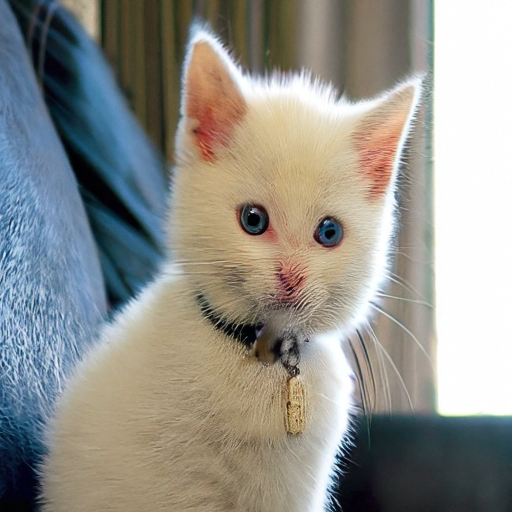

In [121]:
import tarfile
from IPython.display import Image

# get s3 path and extract prefix
model_artifacts_s3_path = huggingface_estimator.latest_training_job.describe()["ModelArtifacts"]["S3ModelArtifacts"]
print(model_artifacts_s3_path)

output_s3_path = model_artifacts_s3_path.replace("model.tar.gz", "output.tar.gz")
print(output_s3_path)

prefix = output_s3_path.replace(f"s3://{bucket}/", "")
print(prefix)

# download artifacts
sess.download_data("./", bucket, key_prefix=prefix)

# extract
with tarfile.open("./output.tar.gz", "r") as f:
    f.extractall()

# check image
Image(filename="upsampled_cat.png", width=632, height=632)

# before upscale

In [120]:
Image(url="https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd2-upscale/low_res_cat.png")

# reference
- [huggingface official url](https://huggingface.co/stabilityai/stable-diffusion-x4-upscaler)
- [huggingface estimator example](https://github.com/huggingface/notebooks/blob/main/sagemaker/05_spot_instances/sagemaker-notebook.ipynb)
- [SageMaker jumpstart notebook:stable diffusion upscaler](https://github.com/Renya-Kujirada/aws-sagemaker-stable-diffusion/blob/main/model-upscaling-stabilityai-stable-diffusion-x4-upscaler-fp16-SDK.ipynb)
- [AWS SageMaker Training(座学編)](https://pages.awscloud.com/rs/112-TZM-766/images/202205_AWS_Black_Belt_AIML_Dark_01_AmazonSageMakerTraining.pdf)
- [SageMaker-training-toolkit Environment variables](https://github.com/aws/sagemaker-training-toolkit/blob/master/ENVIRONMENT_VARIABLES.md#sm_channels)
- [SageMaker sdeep-learning-containers](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#huggingface-training-containers)

---

# その他メモ

## batch transform jobとの差分
- 今回は，推論実行コードをtraining jobで動かせることを検証した．
  - 本来上記はAWSが想定している利用方法ではない．しかし，例えばframework processorなどを利用してsagemaker pipelineの1つのstepとして実行することはできそうだと確認できた．
- sagemaker jumpstartのモデルを利用することで，推論コードを書かずともモデルを動かすことは可能．
- しかし，以下の点においてデメリットがあると考えられる．
  - 入出力をbase64に変換する必要がある（出力データは全てbase64にエンコードされた状態）．
  - 試行錯誤がしづらい可能性あり．例えば，入力画像に対して簡単な前処理を施す等．（sagemaker側から提供されているinference.pyを修正すれば良さそうなのだが，やや難易度は高そう．）
  - 実験毎のハイパラの記録などは，sagemaker experimentsと紐付けられないかもしれない
  
## huggingface docker imageのretrive
- huggingfaceのimageを`image_uris.retrieve()`で取得する際，以下の点に注意すること（公式ドキュメントに引数の説明が書いてないため，コードを見て理解するしか無い．）
  - frameworkには`huggingface`を指定
  - base_framework_versionには`pytorch2.0.0`を指定
  - training jobの場合，image_scopeは`training`にする必要がある．

## pytorch estimatorでも実行できるのか？
- 可能．

In [44]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    image_uri            = image_uri, # s3 uri where our checkpoints will be uploaded during training
    entry_point          = 'main_sd_x4_upscale.py',     # fine-tuning script used in training jon
    # source_dir           = './scripts',       # directory where fine-tuning script is stored
    instance_type        = instance_type,   # instances type used for the training job
    instance_count       = 1,                 # the number of instances used for training
    base_job_name        = base_job_name,     # the name of the training job
    role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
    # transformers_version = '4.26.0',          # the transformers version used in the training job
    # pytorch_version      = '1.13.1',           # the pytorch_version version used in the training job
    # py_version           = 'py310',            # the python version used in the training job
    # hyperparameters      = hyperparameters,   # the hyperparameter used for running the training job
    use_spot_instances   = use_spot_instances,# wether to use spot instances or not
    max_wait             = max_wait,          # max time including spot start + training time
    max_run              = max_run,           # max expected training time
)

In [45]:
estimator.fit()

INFO:sagemaker:Creating training-job with name: sd-x4-upscale-inference-2023-08-26-10-1-2023-08-26-10-10-15-617


Using provided s3_resource
2023-08-26 10:10:16 Starting - Starting the training job...
2023-08-26 10:10:41 Starting - Preparing the instances for training......
2023-08-26 10:11:46 Downloading - Downloading input data...
2023-08-26 10:12:07 Training - Downloading the training image...........................
2023-08-26 10:16:33 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-26 10:16:50,901 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-26 10:16:50,919 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-26 10:16:50,931 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-08-26 10:16:50,933 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-08-26 10:16:52,809 sagemaker-training-toolk

## 利用イメージによるエラー
inference用のイメージを利用すると以下のエラーになる．training用のイメージを利用するとtraining jobは実行可能．

https://discuss.huggingface.co/t/no-space-left-on-device-when-using-huggingface-sagemaker/5406/28

```
Traceback (most recent call last):
  File "/usr/local/bin/dockerd-entrypoint.py", line 25, in <module>
    subprocess.check_call(shlex.split(" ".join(sys.argv[1:])))
  File "/opt/conda/lib/python3.8/subprocess.py", line 359, in check_call
    retcode = call(*popenargs, **kwargs)
  File "/opt/conda/lib/python3.8/subprocess.py", line 340, in call
    with Popen(*popenargs, **kwargs) as p:
  File "/opt/conda/lib/python3.8/subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/opt/conda/lib/python3.8/subprocess.py", line 1704, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)
                        
FileNotFoundError: [Errno 2] No such file or directory: 'train'
```